# OpenVaccine: COVID-19 mRNA Vaccine Degradation Prediction

[kaggle competition site](https://www.kaggle.com/c/stanford-covid-vaccine) 

Dataset description:
- train set:                    2400 examples of length=107 and scoring_length=68
- public test set:              629  examples of length=107 and scoring_length=68
- private test set:             3005 examples of length=130 and scoring_length=91

### TODO:
- [X] no testing model, one model with different testing and training outputs
- [ ] augmentation
- [X] GCN
- [X] sequence fragmentation and similarieties finding

## Import section

In [4]:
%%time
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import LSTM, Dense, Input, TimeDistributed, Concatenate, Lambda, Bidirectional, Dropout, RNN
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD

import spektral
from spektral.layers import GraphConv, GraphAttention, GlobalAttentionPool

import seaborn as sns
import numpy as np
import pandas as pd

from data_preparation import *
from visualization import *
from subgraphing import Subgraphing
from custom_lstm_cell import CustomLSTMCell
from graph_reduce_cell import GraphReduceCell
from submit import *

import time
from datetime import datetime

CPU times: user 2.95 s, sys: 1.26 s, total: 4.21 s
Wall time: 9.65 s


In [5]:
%load_ext tensorboard

# Data Loading

In [6]:
# Dataset constants
STACKED_FEATURES_SIZE = 14
EDGES_FEATURES_MATRIX_DEPTH = 3
NEIGHBOURHOOD_SIZE = 15

In [7]:
%time raw_train_valid_ds, raw_public_test_ds, raw_private_test_ds = get_raw_datasets()

CPU times: user 2.32 s, sys: 789 ms, total: 3.11 s
Wall time: 3.16 s


In [8]:
%time subgraphed_train_valid_ds, subgraphed_public_test_ds, subgraphed_private_test_ds = load_subgraphed_datasets(neighbourhood_size=15) 

CPU times: user 374 ms, sys: 216 ms, total: 591 ms
Wall time: 961 ms


# Model

### Definition

In [9]:
def create_model_for_subgraphed_dataset(neighbourhood_size, stacked_features_size, edges_features_matrix_depth, units):
    base_inputs = Input(shape = (None, neighbourhood_size, stacked_features_size), name='stacked_base_features')
    adjacency_matrix_inputs = Input(shape=(neighbourhood_size, None, None), name='adjacency_matrix')
    edges_features_matrix_inputs = Input(shape=(neighbourhood_size, None, None, edges_features_matrix_depth), name='edges_features_matrix')

    inputs = (base_inputs, adjacency_matrix_inputs, edges_features_matrix_inputs)

    x = RNN(GraphReduceCell(units), return_sequences=True)(inputs)

    reactivity_pred = TimeDistributed(Dense(1), name='reactivity')(x)
    deg_Mg_pH10_pred = TimeDistributed(Dense(1), name='deg_Mg_pH10')(x)
    deg_Mg_50C_pred = TimeDistributed(Dense(1), name='deg_Mg_50C')(x)

    scored_outputs = [reactivity_pred, deg_Mg_pH10_pred, deg_Mg_50C_pred]
    stacked_scored_outputs = Concatenate(axis=2, name='stacked_outputs')(scored_outputs)
    outputs = {'stacked_scored_labels': stacked_scored_outputs}

    model = Model(inputs=inputs, outputs=outputs)
    
    return model

Submissions are scored using MCRMSE (mean columnwise root mean squared error):
$\textrm{MCRMSE} = \frac{1}{N_{t}}\sum_{j=1}^{N_{t}}\sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_{ij} - \hat{y}_{ij})^2}$

In [10]:
def mcrmse(y_true, y_pred):
    rmse = tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred), axis=1))
    return tf.reduce_mean(rmse, axis=1)

### Instantiation

In [11]:
UNITS = 128

model = create_model_for_subgraphed_dataset(NEIGHBOURHOOD_SIZE, STACKED_FEATURES_SIZE, EDGES_FEATURES_MATRIX_DEPTH, UNITS)

log_dir = os.path.join(os.getcwd(), 'logs')
model_name = datetime.now().strftime('model_%Y_%m_%d__%H_%M_%S')
model_log_dir = os.path.join(log_dir, model_name)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=model_log_dir, histogram_freq=0, update_freq='epoch')

model.compile(loss=mcrmse,
#               optimizer=tf.keras.optimizers.SGD(0.01, momentum=0.9),
              optimizer='adam')

### Inspection

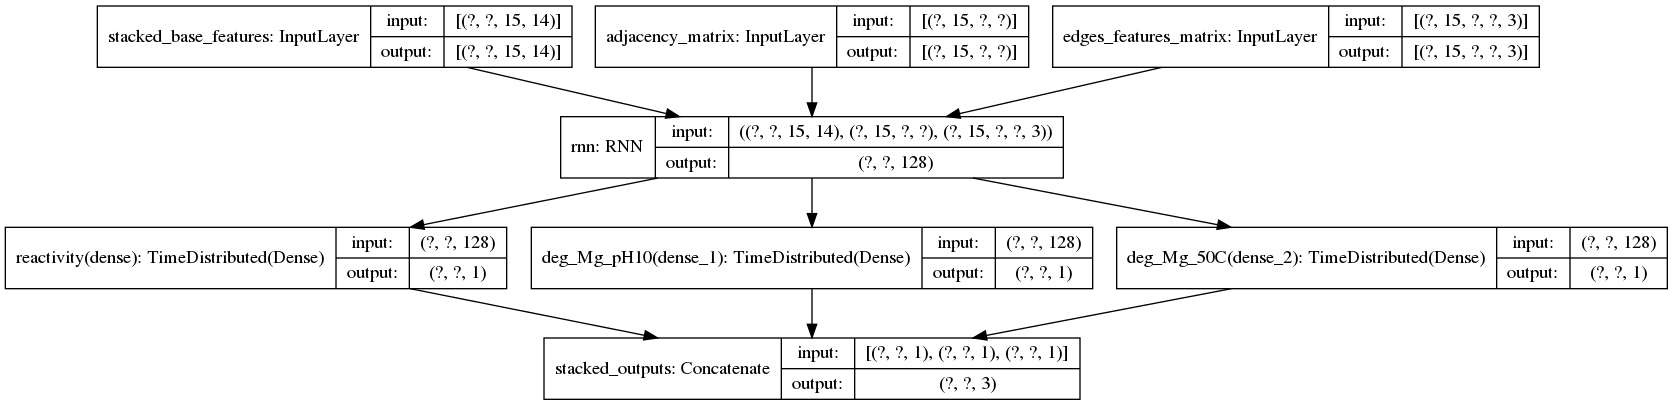

In [12]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [13]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
stacked_base_features (InputLay [(None, None, 15, 14 0                                            
__________________________________________________________________________________________________
adjacency_matrix (InputLayer)   [(None, 15, None, No 0                                            
__________________________________________________________________________________________________
edges_features_matrix (InputLay [(None, 15, None, No 0                                            
__________________________________________________________________________________________________
rnn (RNN)                       (None, None, 128)    35200       stacked_base_features[0][0]      
                                                                 adjacency_matrix[0][0]

model.evaluate(subgraphed_valid_ds.batch(64))# Additional dataset preparations

In [17]:
subgraphed_train_ds, subgraphed_valid_ds = split_into_train_and_valid(subgraphed_train_valid_ds, split_factor=0.3)

### Baseline training and testing models evaluation

In [19]:
model.evaluate(subgraphed_valid_ds.batch(64))

12/12 [==============================] - 0s 37ms/step - loss: 1.0374


1.037444829940796

# Model training

In [21]:
%tensorboard --logdir $log_dir

In [22]:
history = model.fit(subgraphed_train_ds.batch(32),
                    validation_data=subgraphed_valid_ds.batch(4096),
                    epochs=10,
                    initial_epoch=0,
                    verbose=1,
                    shuffle=True,
                    callbacks=[tensorboard_callback])

Epoch 1/10


/home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['sequence', 'structure', 'predicted_loop_type', 'seq_scored'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


 1/53 [..............................] - ETA: 0s - loss: 1.0013WARNING:tensorflow:From /home/jan/.local/share/virtualenvs/covid-EPTM6kfD/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
53/53 [==============================] - 9s 164ms/step - loss: 0.6036 - val_loss: 0.5831
Epoch 2/10
53/53 [==============================] - 8s 150ms/step - loss: 0.5645 - val_loss: 0.5546
Epoch 3/10
53/53 [==============================] - 8s 151ms/step - loss: 0.5740 - val_loss: 0.5588
Epoch 4/10
53/53 [==============================] - 8s 153ms/step - loss: 0.5825 - val_loss: 0.5549
Epoch 5/10
53/53 [==============================] - 8s 153ms/step - loss: 0.5778 - val_loss: 0.5645
Epoch 6/10
53/53 [==============================] - 8s 153ms/step - loss: 0.5598 - val_loss: 0.5670
Epoch 7/10
53/53 [=============

# Create submission

In [23]:
%time submission = create_submission(model, [subgraphed_public_test_ds, subgraphed_private_test_ds], [raw_public_test_ds, raw_private_test_ds])
submission

CPU times: user 8.37 s, sys: 1.69 s, total: 10.1 s
Wall time: 16.9 s


,id_seqpos,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,id_00073f8be_0,0.563792,0.582110,0.0,0.514931,0.0
1,id_00073f8be_1,0.563792,0.582110,0.0,0.514931,0.0
2,id_00073f8be_2,0.563792,0.582110,0.0,0.514931,0.0
3,id_00073f8be_3,0.563792,0.582110,0.0,0.514931,0.0
4,id_00073f8be_4,0.563792,0.582110,0.0,0.514931,0.0
...,...,...,...,...,...,...
316222,id_ffda94f24_86,0.436439,0.529353,0.0,0.411732,0.0
316223,id_ffda94f24_87,0.430669,0.508158,0.0,0.411452,0.0
316224,id_ffda94f24_88,0.430669,0.508158,0.0,0.411452,0.0
316225,id_ffda94f24_89,0.430669,0.508158,0.0,0.411452,0.0


In [24]:
submission_name = 'submission.csv'
submission_path = os.path.join(os.getcwd(), submission_name)
submission.to_csv(submission_path, header=True, index=False)

# Model saving and loading

In [25]:
model_file_name = 'model'
model_path = os.path.join(os.getcwd(), model_file_name)

In [27]:
# loaded_model = tf.keras.models.load_model(model_path, custom_objects={'mcrmse': mcrmse, 'GraphReduceCell': GraphReduceCell})

In [ ]:
# model = loaded_model

In [26]:
model.save(model_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /home/jan/kaggle_competitions/covid/model/assets


TODO:
* cross-validation - more data to train
* signal_to_noise parameter - maybe it can be used in some way
* unsupervised pretraining